In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.1


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [4]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_data()
X_train.shape

(3328, 96, 96, 3)

In [5]:
model = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

9406464/9406464 [==============================] - 1s 0us/step


In [6]:
model.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))
x = model(inputs, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
output = tfkl.Dense(1)(x)
tl_model = tfk.Model(inputs, output, name="modelX")
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.BinaryAccuracy()])
tl_model.summary()

Model: "modelX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [7]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing
    y = y_train,
    batch_size = 16,
    epochs = 20,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/20
208/208 [==============================] - 15s 65ms/step - loss: 0.5223 - binary_accuracy: 0.7311 - val_loss: 0.4766 - val_binary_accuracy: 0.7392
Epoch 2/20
208/208 [==============================] - 12s 59ms/step - loss: 0.4092 - binary_accuracy: 0.8092 - val_loss: 0.4431 - val_binary_accuracy: 0.7788
Epoch 3/20
208/208 [==============================] - 12s 56ms/step - loss: 0.3761 - binary_accuracy: 0.8263 - val_loss: 0.4429 - val_binary_accuracy: 0.7788
Epoch 4/20
208/208 [==============================] - 12s 59ms/step - loss: 0.3573 - binary_accuracy: 0.8338 - val_loss: 0.4269 - val_binary_accuracy: 0.7933
Epoch 5/20
208/208 [==============================] - 12s 59ms/step - loss: 0.3376 - binary_accuracy: 0.8474 - val_loss: 0.4230 - val_binary_accuracy: 0.7969
Epoch 6/20
208/208 [==============================] - 12s 57ms/step - loss: 0.3239 - binary_accuracy: 0.8513 - val_loss: 0.4194 - val_binary_accuracy: 0.7993
Epoch 7/20
208/208 [==============================] 

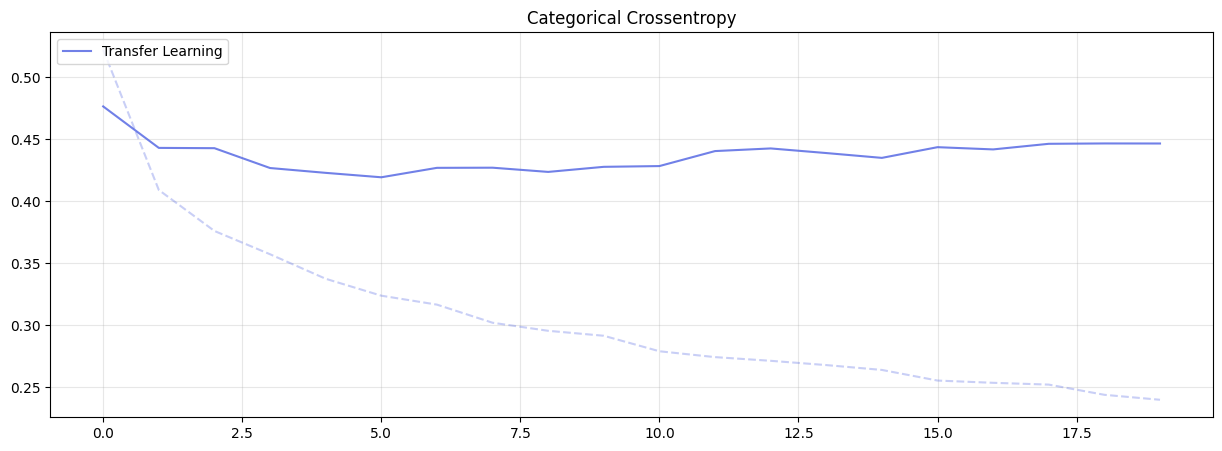

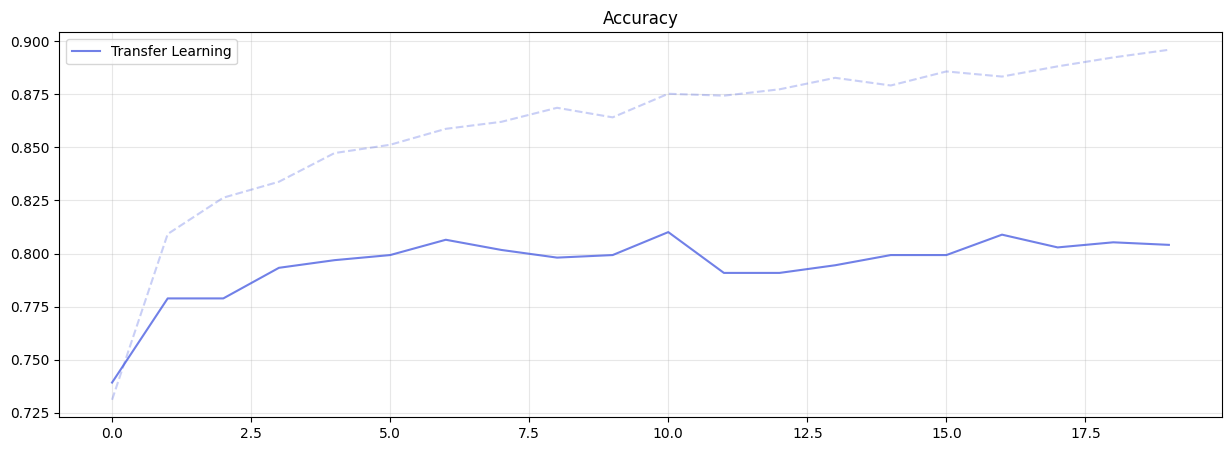

In [8]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['binary_accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_binary_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [10]:
# Save the best model
tl_model.save('MobileTransferLearning')
del tl_model

In [11]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('MobileTransferLearning')
ft_model.summary()

Model: "modelX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [13]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [14]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [16]:
for l in ft_model.layers:
    print(l.name, l.trainable)

input_2 True
mobilenetv2_1.00_96 True
global_average_pooling2d True
dense True


In [20]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [21]:
ft_model.summary()

Model: "modelX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1207361 (4.61 MB)
Non-trainable params: 1051904 (4.01 MB)
_________________________________________________________________


In [22]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
208/208 [==============================] - 21s 90ms/step - loss: 4.5886e-08 - accuracy: 0.6151 - val_loss: 4.5850e-08 - val_accuracy: 0.6154
Epoch 2/200
208/208 [==============================] - 17s 81ms/step - loss: 4.5886e-08 - accuracy: 0.6151 - val_loss: 4.5850e-08 - val_accuracy: 0.6154
Epoch 3/200
208/208 [==============================] - 17s 84ms/step - loss: 4.5886e-08 - accuracy: 0.6151 - val_loss: 4.5850e-08 - val_accuracy: 0.6154
Epoch 4/200
208/208 [==============================] - 17s 83ms/step - loss: 4.5886e-08 - accuracy: 0.6151 - val_loss: 4.5850e-08 - val_accuracy: 0.6154
Epoch 5/200
208/208 [==============================] - 17s 84ms/step - loss: 4.5886e-08 - accuracy: 0.6151 - val_loss: 4.5850e-08 - val_accuracy: 0.6154
Epoch 6/200
208/208 [==============================] - 17s 84ms/step - loss: 4.5886e-08 - accuracy: 0.6151 - val_loss: 4.5850e-08 - val_accuracy: 0.6154
Epoch 7/200
208/208 [==============================] - 18s 85ms/step - loss: 4.588